## Mask R-CNN - Inspect Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [63]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import skimage

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn.config import Config
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "weights/mask_rcnn_carplate_0970_25.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Path to Shapes trained weights
SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_shapes.h5")

## Configurations

In [64]:
# Run one of the code blocks

# Shapes toy dataset
# import shapes
# config = shapes.ShapesConfig()

class CarPlateConfig(Config):


    NAME = 'carplate'

    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 33

    STEPS_PER_EPOCH = 100

    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)

    RPN_ANCHOR_RATIOS = [0.3, 0.6, 1]

    RPN_TRAIN_ANCHORS_PER_IMAGE = 500

    IMAGE_MIN_DIM = int(480)
    IMAGE_MAX_DIM = int(640)
    POST_NMS_ROIS_INFERENCE = 2000
    TRAIN_ROIS_PER_IMAGE = 400
    DETECTION_MIN_CONFIDENCE=0.5

    MEAN_PIXEL = np.array([0.449122045 * 255, 0.449122045 * 255, 0.449122045 * 255 ])

    LEARNING_RATE = 0.005

In [65]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(CarPlateConfig):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                46
IMAGE_MIN_DIM                  480
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.005
LOSS_WEIGHTS                   {'rpn_class_loss': 0.5, 'rpn_bbox_loss': 2.0, 'mrcnn_class_loss': 2.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [66]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [67]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [68]:
class CarPlateDataset(utils.Dataset):



    def load_carplates(self, dataset_dir, subset):

        self.add_class("carplate", 1, "0")
        self.add_class("carplate", 2, "1")
        self.add_class("carplate", 3, "2")
        self.add_class("carplate", 4, "3")
        self.add_class("carplate", 5, "4")
        self.add_class("carplate", 6, "5")
        self.add_class("carplate", 7, "6")
        self.add_class("carplate", 8, "7")
        self.add_class("carplate", 9, "8")
        self.add_class("carplate", 10, "9")
        self.add_class("carplate", 11, "A")
        self.add_class("carplate", 12, "B")
        self.add_class("carplate", 13, "C")
        self.add_class("carplate", 14, "D")
        self.add_class("carplate", 15, "E")
        self.add_class("carplate", 16, "F")
        self.add_class("carplate", 17, "G")
        self.add_class("carplate", 18, "H")
        self.add_class("carplate", 19, "J")
        self.add_class("carplate", 20, "K")
        self.add_class("carplate", 21, "L")
        self.add_class("carplate", 22, "M")
        self.add_class("carplate", 23, "N")
        self.add_class("carplate", 24, "P")
        self.add_class("carplate", 25, "R")
        self.add_class("carplate", 26, "S")
        self.add_class("carplate", 27, "T")
        self.add_class("carplate", 28, "U")
        self.add_class("carplate", 29, "V")
        self.add_class("carplate", 30, "W")
        self.add_class("carplate", 31, "X")
        self.add_class("carplate", 32, "Y")
        self.add_class("carplate", 33, "Z")
        # self.add_class("carplate", 1, "carplate")
        name_dict = {"0": 1,
                         "1": 2,
                         "2": 3,
                         "3": 4,
                         "4": 5,
                         "5": 6,
                         "6": 7,
                         "7": 8,
                         "8": 9,
                         "9": 10,
                         "A": 11,
                         "B": 12,
                         "C": 13,
                         "D": 14,
                         "E": 15,
                         "F": 16,
                         "G": 17,
                         "H": 18,
                         "J": 19,
                         "K": 20,
                         "L": 21,
                         "M": 22,
                         "N": 23,
                         "P": 24,
                         "R": 25,
                         "S": 26,
                         "T": 27,
                         "U": 28,
                         "V": 29,
                         "W": 30,
                         "X": 31,
                         "Y": 32,
                         "Z": 33
                         }
        # name_dict = {
            # "carplate": 1
        # }
        assert subset in ['train', 'val']

        dataset_dir = os.path.join(dataset_dir, subset)
        print("Dataset: ", dataset_dir)

        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))

        annotations = list(annotations.values())  # don't need the dict keys

        annotations = [a for a in annotations if a['regions']]
        
        for a in annotations:
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 
            
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            print(image_path)
            class_ids = [r['region_attributes']['type'] for r in a['regions']]

            name_id = [name_dict[n] for n in class_ids]

            height, width = image.shape[:2]
            self.add_image(
                "carplate",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                class_id = name_id)

    def load_mask(self, image_id):
   
        image_info = self.image_info[image_id]
        if image_info["source"] != "carplate":
            return super(self.__class__, self).load_mask(image_id)
        name_id = image_info["class_id"]
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)

        class_ids = np.array(name_id, dtype=np.int32)
        for i, p in enumerate(info["polygons"]):
            if 'all_points_x' and 'all_points_y' in p:
            # Get indexes of pixels inside the polygon and set them to 1
                rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
                mask[rr, cc, i] = 1
        
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return (mask.astype(np.bool),class_ids)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "carplate":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

# Must call before using the dataset
dataset = CarPlateDataset()
dataset.load_carplates(os.path.join(ROOT_DIR, "true_test_characters"), "val")
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Dataset:  /home/dmitry/Documents/Projects/mask_rcnn_carplate/true_test_characters/val
/home/dmitry/Documents/Projects/mask_rcnn_carplate/true_test_characters/val/2018-11-16 09-08-16屏幕截图.png
/home/dmitry/Documents/Projects/mask_rcnn_carplate/true_test_characters/val/2018-11-16 09-08-40屏幕截图.png
/home/dmitry/Documents/Projects/mask_rcnn_carplate/true_test_characters/val/2018-11-16 09-08-54屏幕截图.png
/home/dmitry/Documents/Projects/mask_rcnn_carplate/true_test_characters/val/2018-11-16 09-09-06屏幕截图.png
/home/dmitry/Documents/Projects/mask_rcnn_carplate/true_test_characters/val/2018-11-16 09-09-17屏幕截图.png
/home/dmitry/Documents/Projects/mask_rcnn_carplate/true_test_characters/val/2018-11-16 09-09-29屏幕截图.png
/home/dmitry/Documents/Projects/mask_rcnn_carplate/true_test_characters/val/2018-11-16 09-09-45屏幕截图.png
/home/dmitry/Documents/Projects/mask_rcnn_carplate/true_test_characters/val/2018-11-16 09-09-53屏幕截图.png
/home/dmitry/Documents/Projects/mask_rcnn_carplate/true_test_characters/val/2018-1

## Load Model

In [69]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# Set weights file path
if config.NAME == "shapes":
    weights_path = SHAPES_MODEL_PATH
elif config.NAME == "carplate":
    weights_path = COCO_MODEL_PATH
# Or, uncomment to load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /home/dmitry/Documents/Projects/mask_rcnn_carplate/weights/mask_rcnn_carplate_0970_25.h5


## Run Detection

image ID: carplate.2018-11-16 09-08-54屏幕截图.png (2) /home/dmitry/Documents/Projects/mask_rcnn_carplate/true_test_characters/val/2018-11-16 09-08-54屏幕截图.png
Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  184.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -114.52612  max:   69.47388  float64
image_metas              shape: (1, 46)               min:    0.00000  max:  640.00000  int64
anchors                  shape: (1, 102300, 4)        min:   -0.36572  max:    1.26556  float32
gt_class_id              shape: (6,)                  min:    2.00000  max:   25.00000  int32
gt_bbox                  shape: (6, 4)                min:   53.00000  max:  523.00000  int32
gt_mask                  shape: (640, 640, 6)         min:    0.00000  max:    1.00000  bool


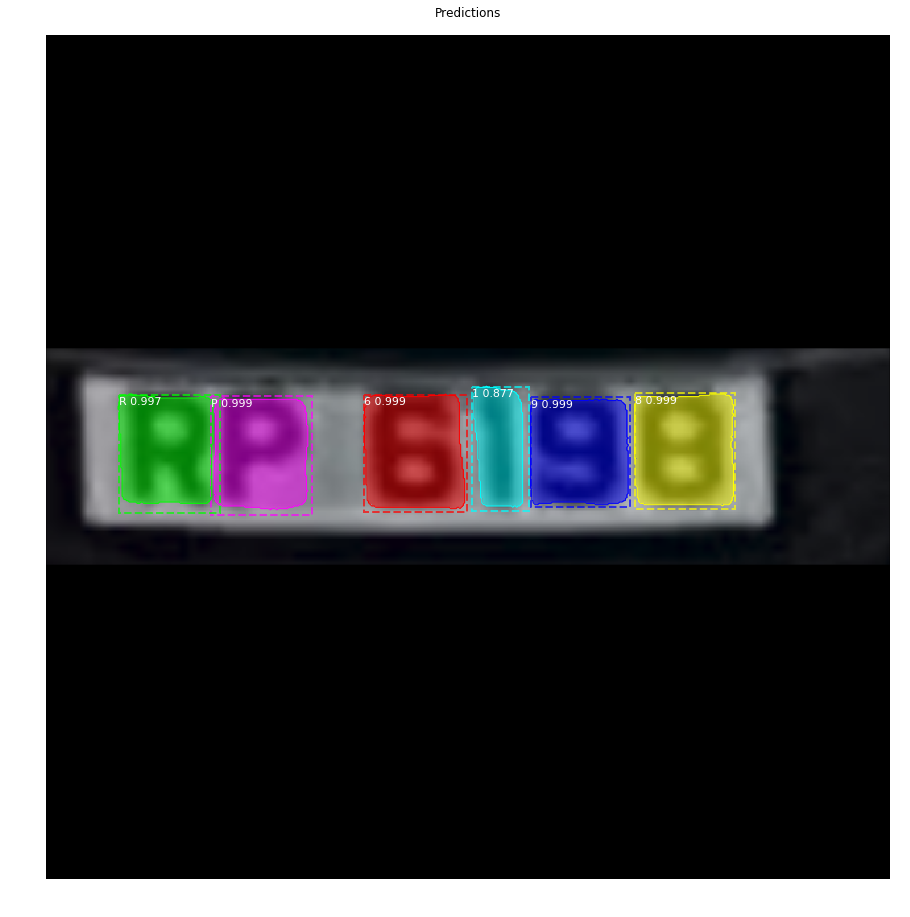

In [70]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

### Precision-Recall

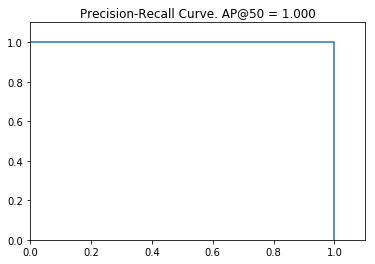

In [71]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

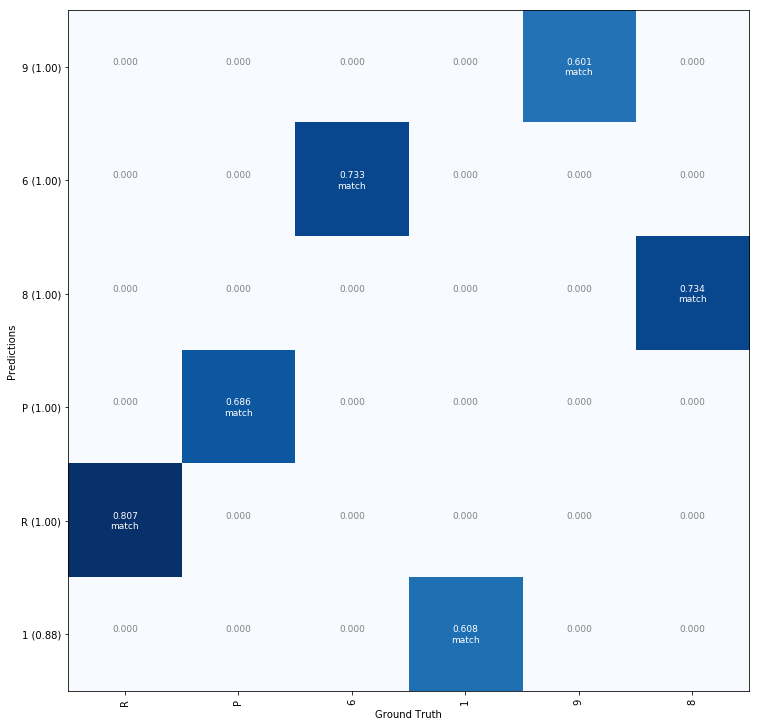

In [72]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

### Compute mAP @ IoU=50 on Batch of Images

In [73]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset.image_ids, 10)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

mAP @ IoU=50:  0.9000000030511902


## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [74]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (102300,)             min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (500, 4)              min:   -1.41203  max:    2.70799  float64
positive_anchors         shape: (6, 4)                min:   55.21291  max:  512.00000  float64
negative_anchors         shape: (494, 4)              min:  -41.31182  max:  692.84748  float64
neutral anchors          shape: (101800, 4)           min: -233.69496  max:  809.69496  float64
refined_anchors          shape: (6, 4)                min:   53.00000  max:  523.00000  float32


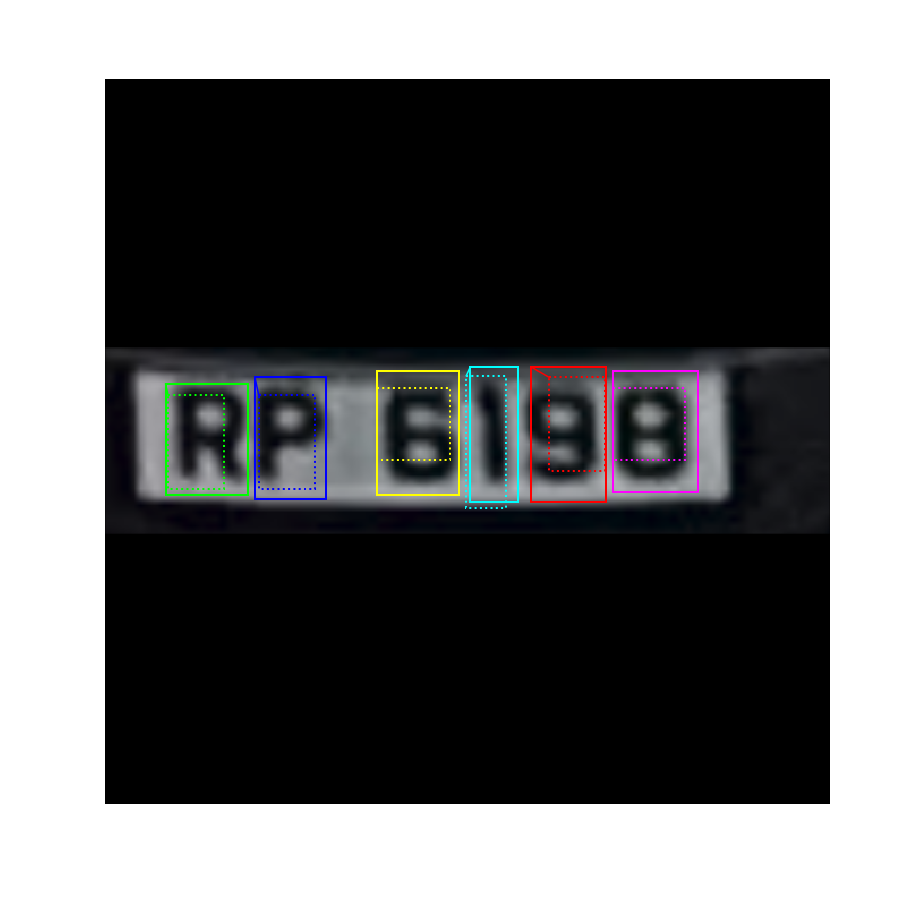

In [75]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [76]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 102300, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.36572  max:    1.26556  float32
refined_anchors          shape: (1, 6000, 4)          min:   -0.56960  max:    1.32336  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (1261,)               min:    0.00000  max: 5995.00000  int32
proposals                shape: (1, 2000, 4)          min:    0.00000  max:    1.00000  float32


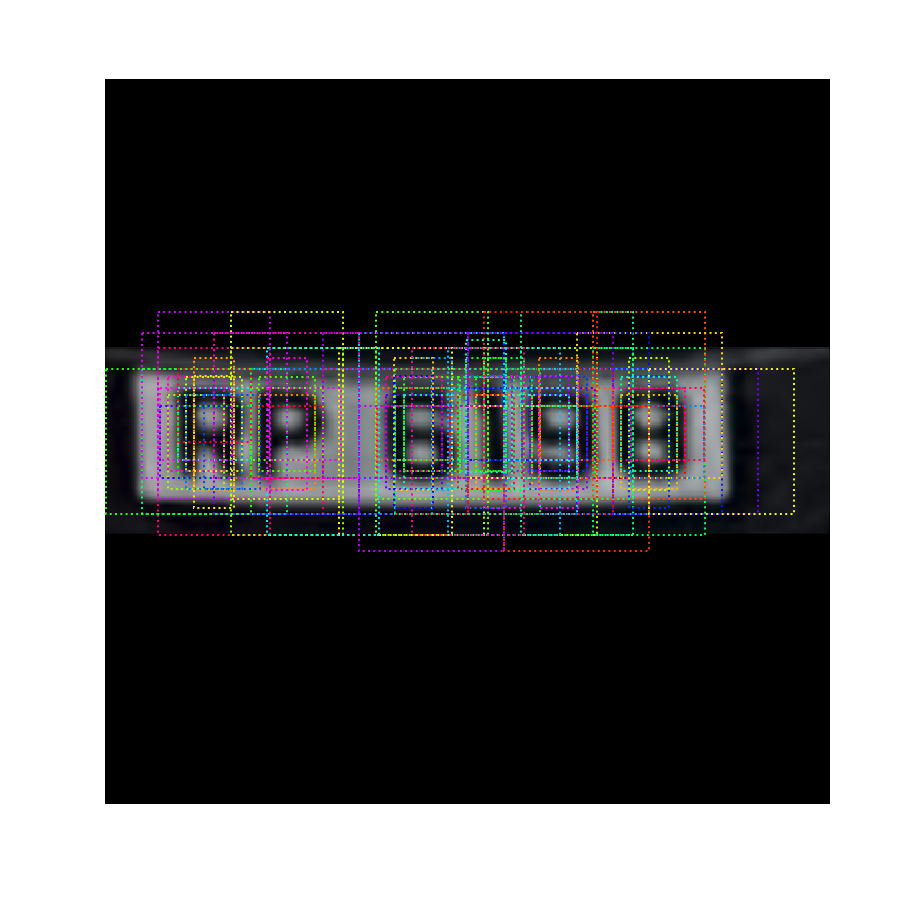

In [77]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

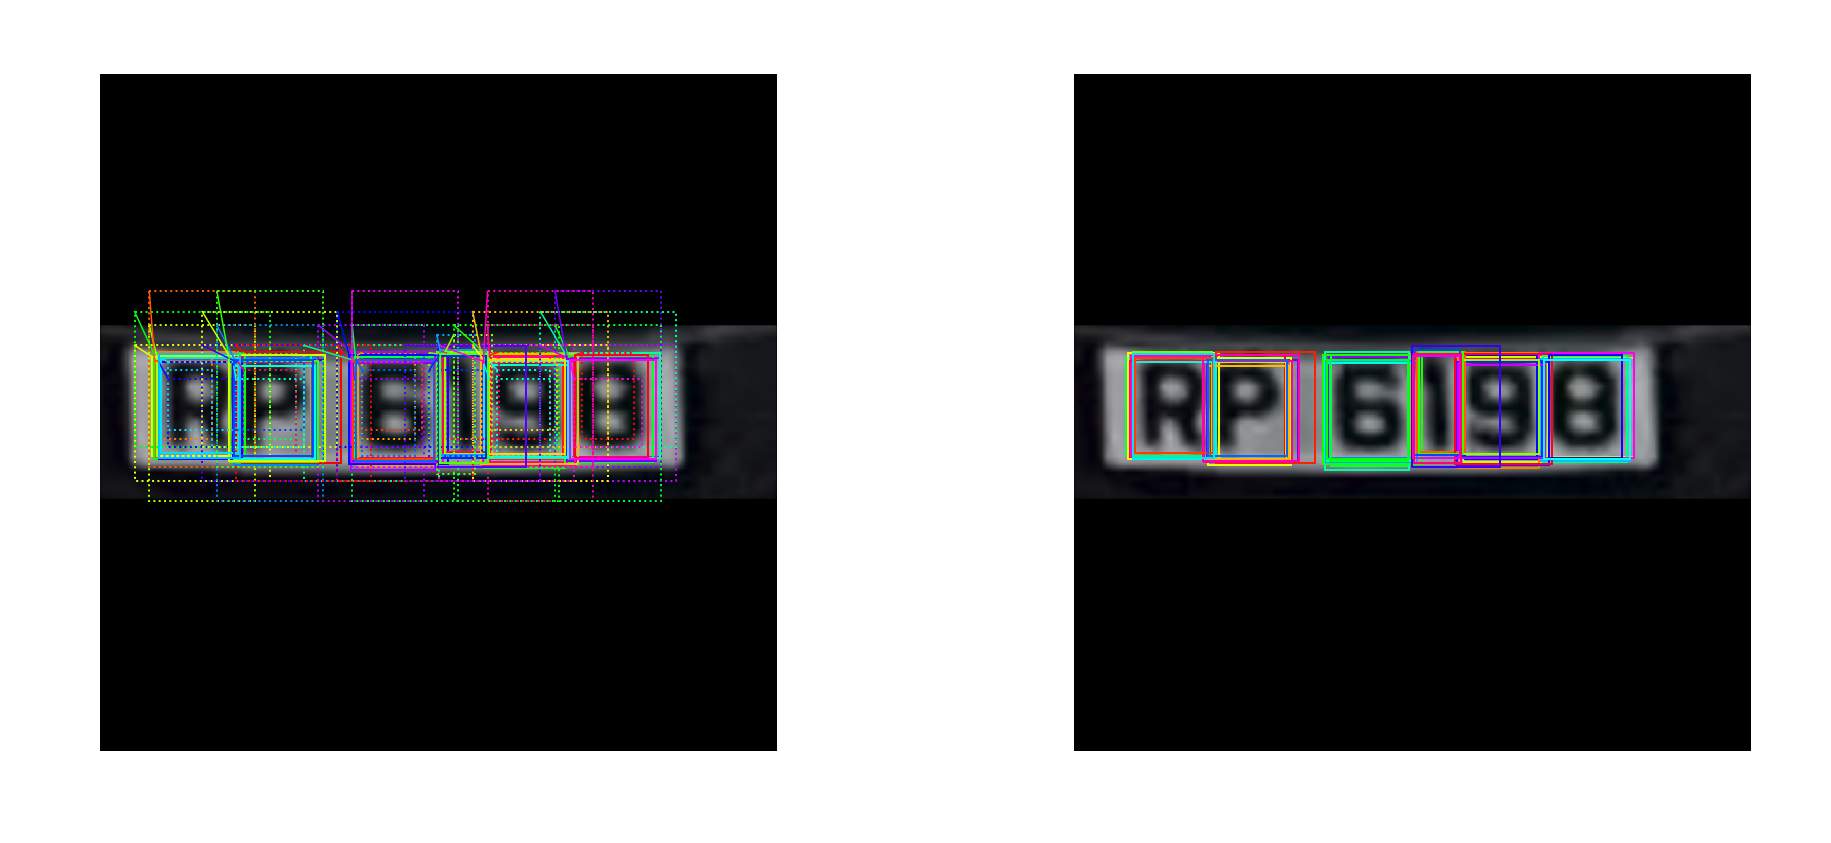

In [78]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

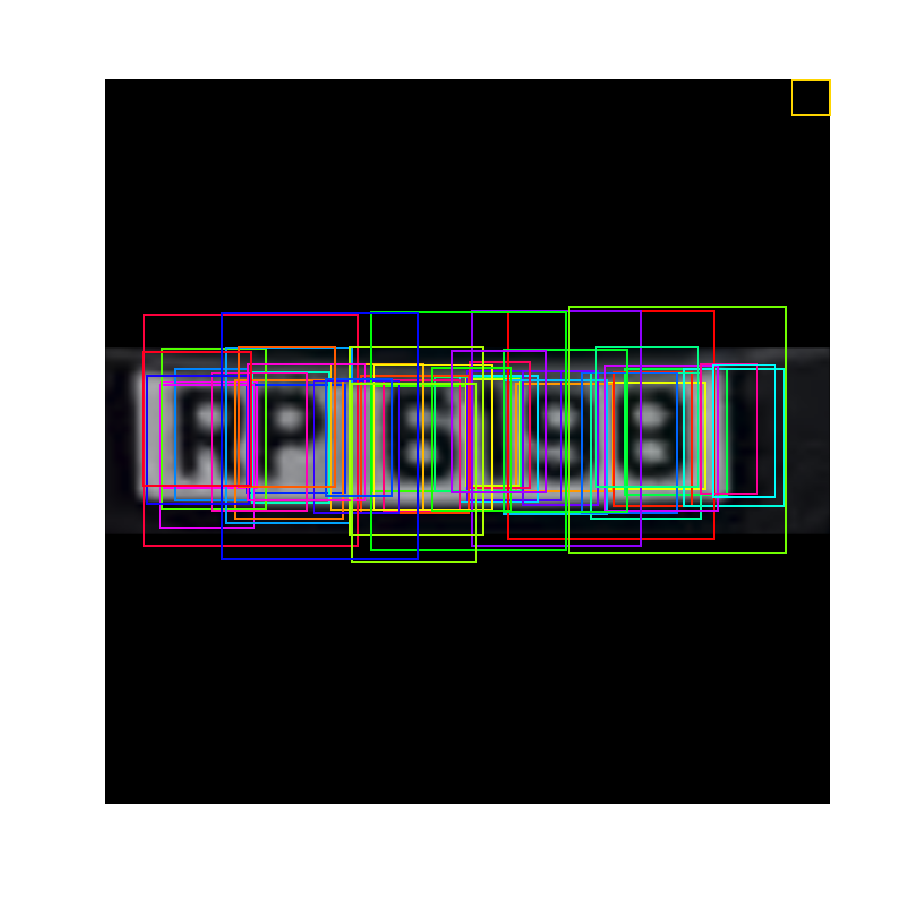

In [79]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

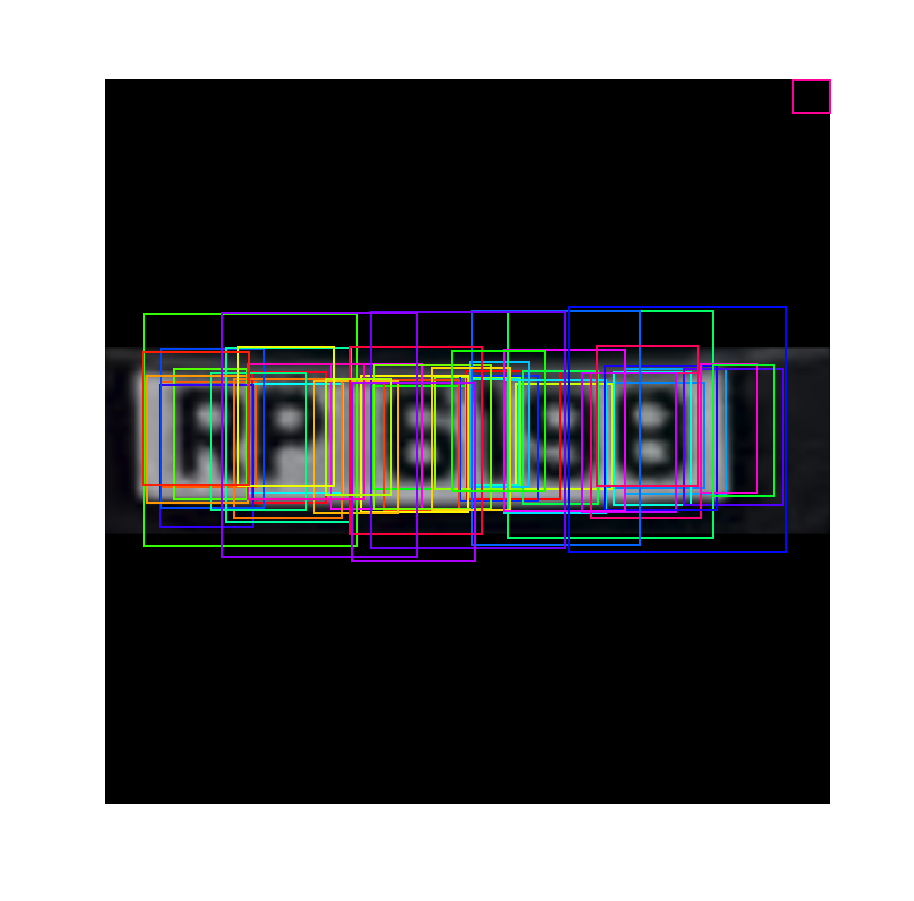

In [80]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

In [81]:
# Measure the RPN recall (percent of objects covered by anchors)
# Here we measure recall for 3 different methods:
# - All anchors
# - All refined anchors
# - Refined anchors after NMS
iou_threshold = 0.7

recall, positive_anchor_ids = utils.compute_recall(model.anchors, gt_bbox, iou_threshold)
print("All Anchors ({:5})       Recall: {:.3f}  Positive anchors: {}".format(
    model.anchors.shape[0], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(rpn['refined_anchors'][0], gt_bbox, iou_threshold)
print("Refined Anchors ({:5})   Recall: {:.3f}  Positive anchors: {}".format(
    rpn['refined_anchors'].shape[1], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(proposals, gt_bbox, iou_threshold)
print("Post NMS Anchors ({:5})  Recall: {:.3f}  Positive anchors: {}".format(
    proposals.shape[0], recall, len(positive_anchor_ids)))


All Anchors (102300)       Recall: 0.000  Positive anchors: 0
Refined Anchors ( 6000)   Recall: 0.000  Positive anchors: 0
Post NMS Anchors (   50)  Recall: 1.000  Positive anchors: 9


## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [82]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 2000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 2000, 34)         min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 2000, 34, 4)      min:   -4.15456  max:    5.10376  float32
masks                    shape: (1, 100, 28, 28, 34)  min:    0.00000  max:    1.00000  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:   25.00000  float32


6 detections: ['9' '6' '8' 'P' 'R' '1']


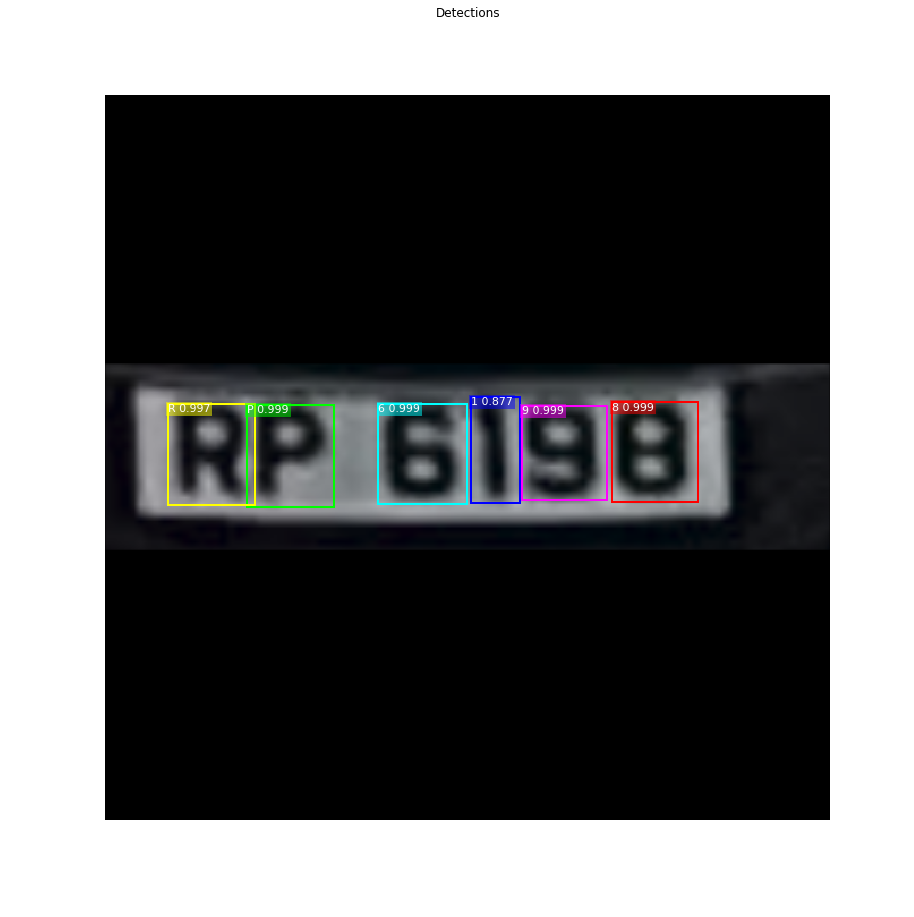

In [83]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [84]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1261 Valid proposals out of 2000
36 Positive ROIs
[('1', 2), ('6', 6), ('8', 7), ('9', 9), ('BG', 1964), ('P', 6), ('R', 6)]


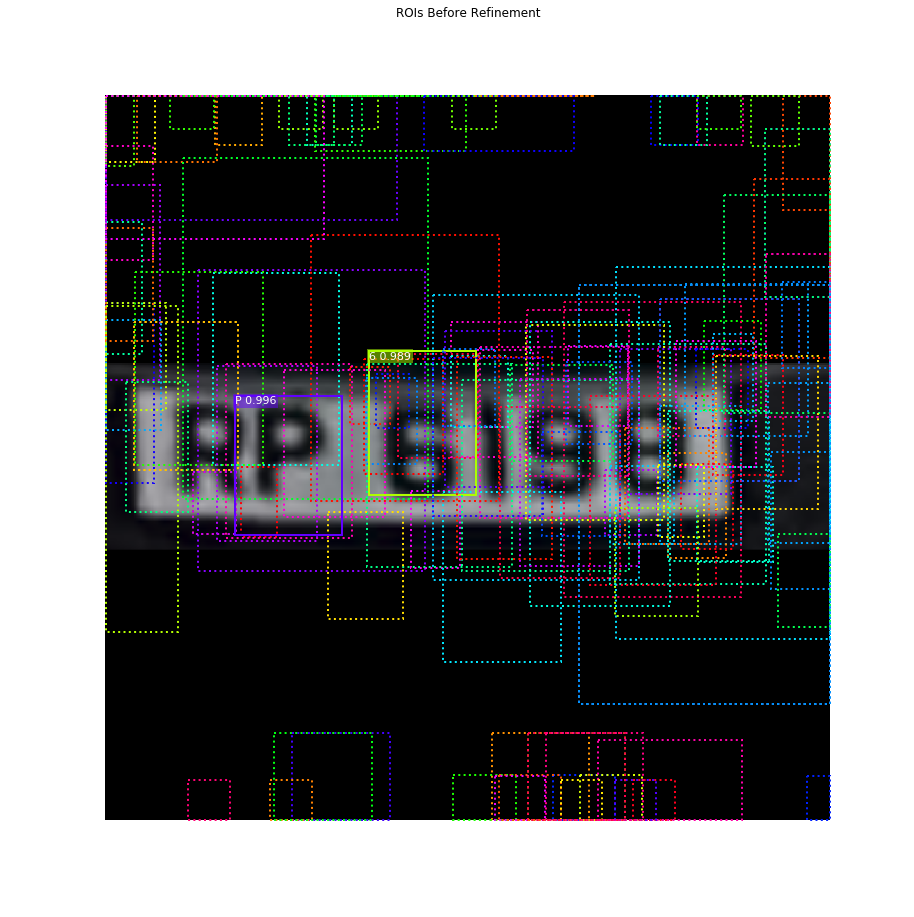

In [85]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (2000, 4)             min:   -3.75127  max:    3.50135  float32
refined_proposals        shape: (2000, 4)             min:  -87.00000  max:  678.00000  int32


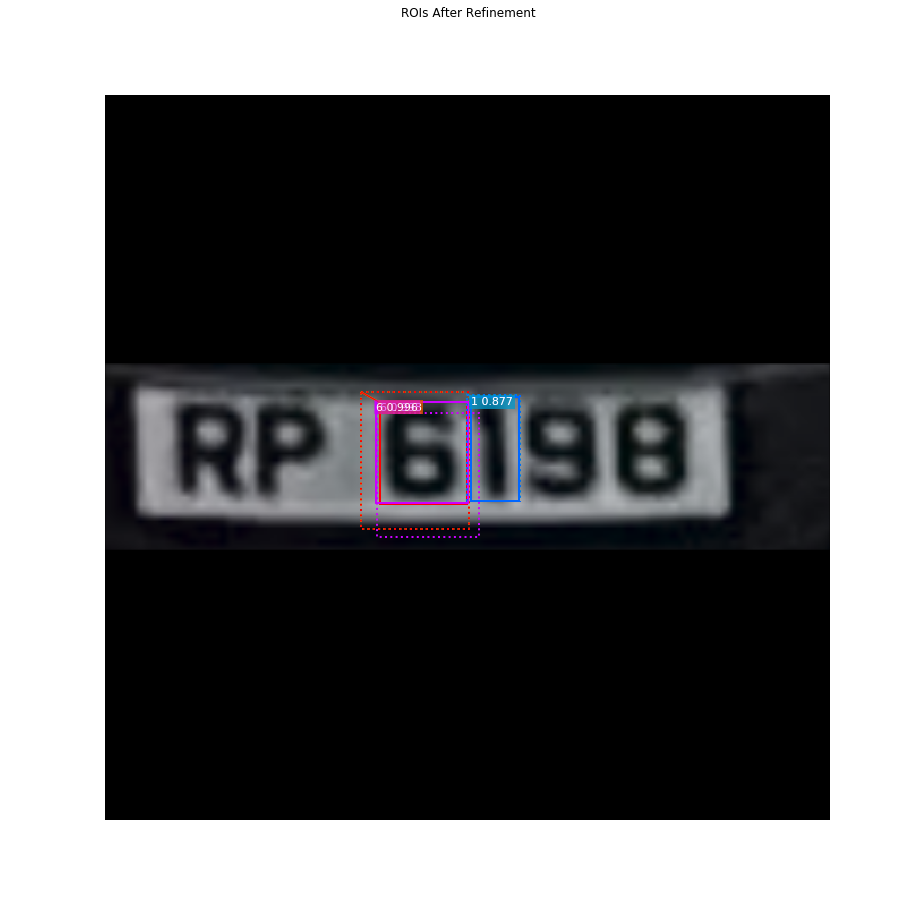

In [86]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [87]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 36 detections:
[   0    1    2    3    4    5    7    9   10   11   12   13   14   15
   16   18   19   21   23   26   29   33   38   41   42   43   46   51
   56   57  184  234  251  672 1093 1182]


In [88]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.5 confidence. Keep 35:
[   0    1    2    3    4    5    7    9   10   11   12   13   14   15
   16   18   19   21   23   26   29   33   38   42   43   46   51   56
   57  184  234  251  672 1093 1182]


#### Per-Class Non-Max Suppression

In [89]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

1                     : [5 7] -> [5]
6                     : [   2   12   16   23   57 1093] -> [2]
8                     : [  0  10  15  18  29  43 672] -> [0]
9                     : [   1    9   14   51   56  184  251 1182] -> [1]
P                     : [  4  13  21  38  42 234] -> [13]
R                     : [ 3 11 19 26 33 46] -> [3]

Kept after per-class NMS: 6
[ 0  1  2  3  5 13]


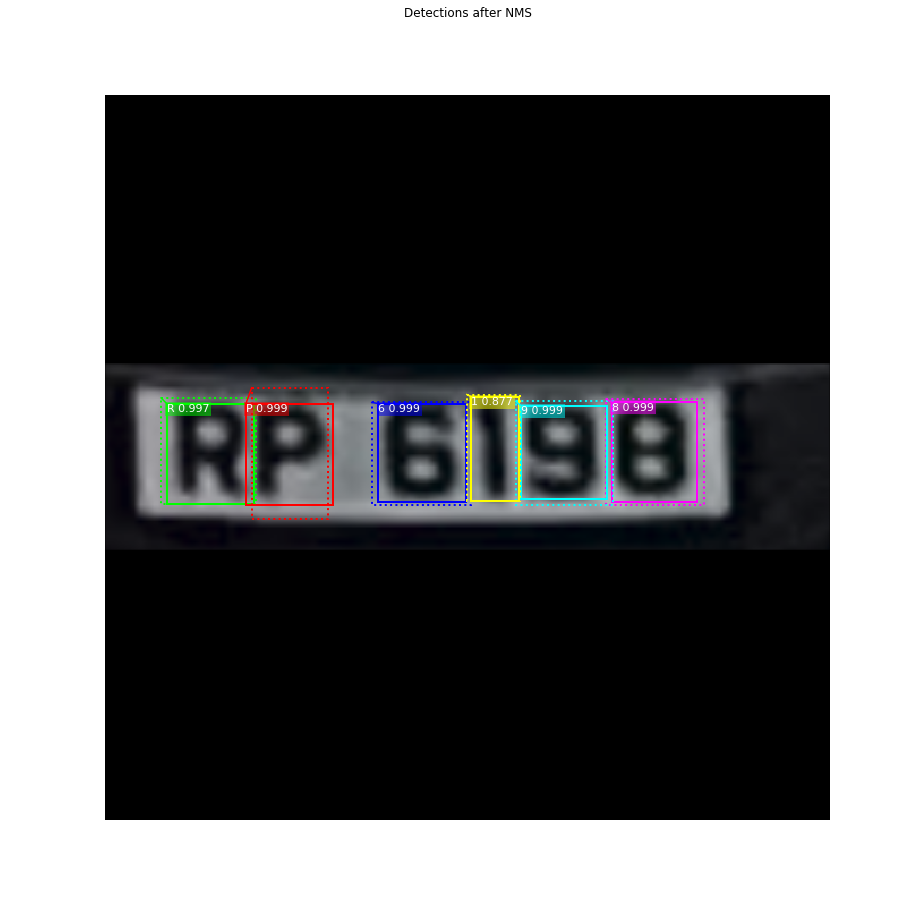

In [90]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

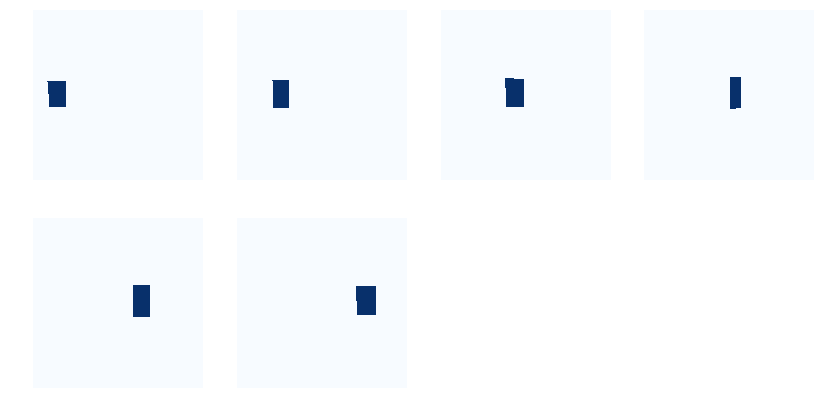

In [91]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [92]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:   25.00000  float32
masks                    shape: (1, 100, 28, 28, 34)  min:    0.00000  max:    1.00000  float32
6 detections: ['9' '6' '8' 'P' 'R' '1']


In [93]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (6, 28, 28)           min:    0.00581  max:    1.00000  float32
det_masks                shape: (6, 640, 640)         min:    0.00000  max:    1.00000  bool


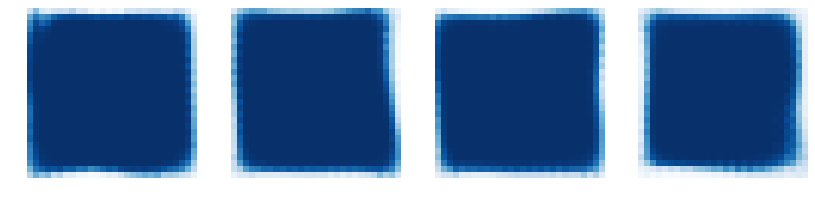

In [94]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

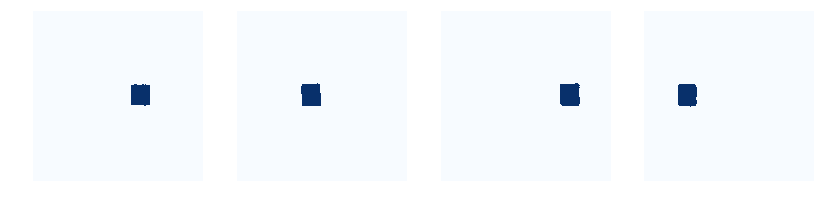

In [95]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [96]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 640, 640, 3)      min: -114.52612  max:   69.47388  float32
res4w_out                shape: (1, 40, 40, 1024)     min:    0.00000  max:   15.04988  float32
rpn_bbox                 shape: (1, 102300, 4)        min:  -19.99325  max:   30.46530  float32
roi                      shape: (1, 2000, 4)          min:    0.00000  max:    1.00000  float32


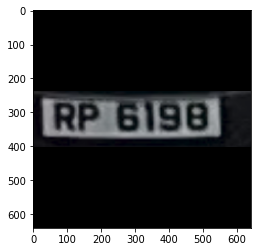

In [97]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

In [98]:
# Backbone feature map
display_images(np.transpose(activations["rpn_bbox"][0,:,:,:4], [2, 0, 1]))

IndexError: too many indices for array

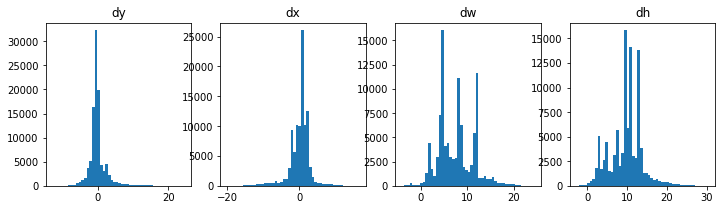

In [99]:
# Histograms of RPN bounding box deltas
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title("dy")
_ = plt.hist(activations["rpn_bbox"][0,:,0], 50)
plt.subplot(1, 4, 2)
plt.title("dx")
_ = plt.hist(activations["rpn_bbox"][0,:,1], 50)
plt.subplot(1, 4, 3)
plt.title("dw")
_ = plt.hist(activations["rpn_bbox"][0,:,2], 50)
plt.subplot(1, 4, 4)
plt.title("dh")
_ = plt.hist(activations["rpn_bbox"][0,:,3], 50)

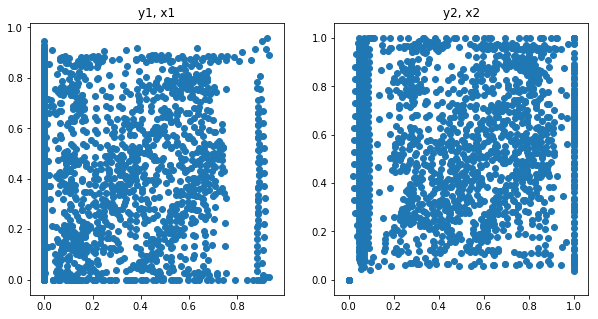

In [62]:
# Distribution of y, x coordinates of generated proposals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("y1, x1")
plt.scatter(activations["roi"][0,:,0], activations["roi"][0,:,1])
plt.subplot(1, 2, 2)
plt.title("y2, x2")
plt.scatter(activations["roi"][0,:,2], activations["roi"][0,:,3])
plt.show()